   Unnamed: 0     id       dur proto service state  spkts  dpkts  sbytes  \
0       40000  40001  0.012996   tcp       -   FIN     16     18    1540   
1       40001  40002  0.004119   tcp       -   FIN     12     12    1064   
2       40002  40003  0.000988   udp     dns   CON      2      2     146   
3       40003  40004  3.415787   tcp     ssh   FIN    230    238   24344   
4       40004  40005  0.193943   tcp       -   FIN     72     74    4238   

   dbytes  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0    1644  ...                 1               6             0           0   
1    2260  ...                 1               1             0           0   
2     178  ...                 1               2             0           0   
3   29556  ...                 1               1             0           0   
4   63618  ...                 1               5             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  

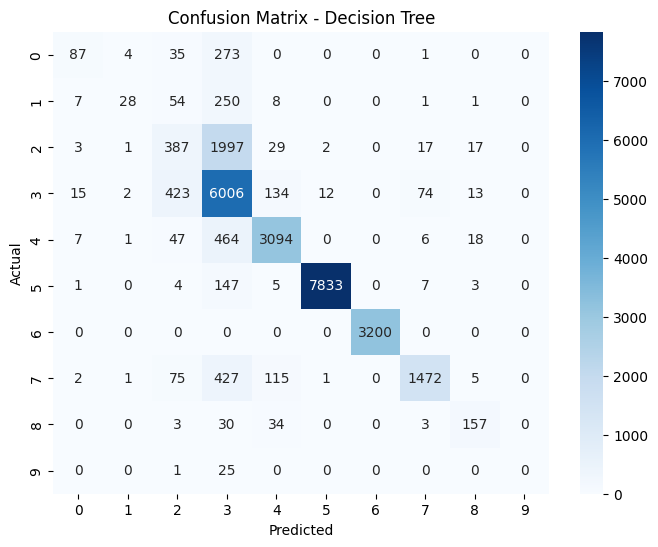

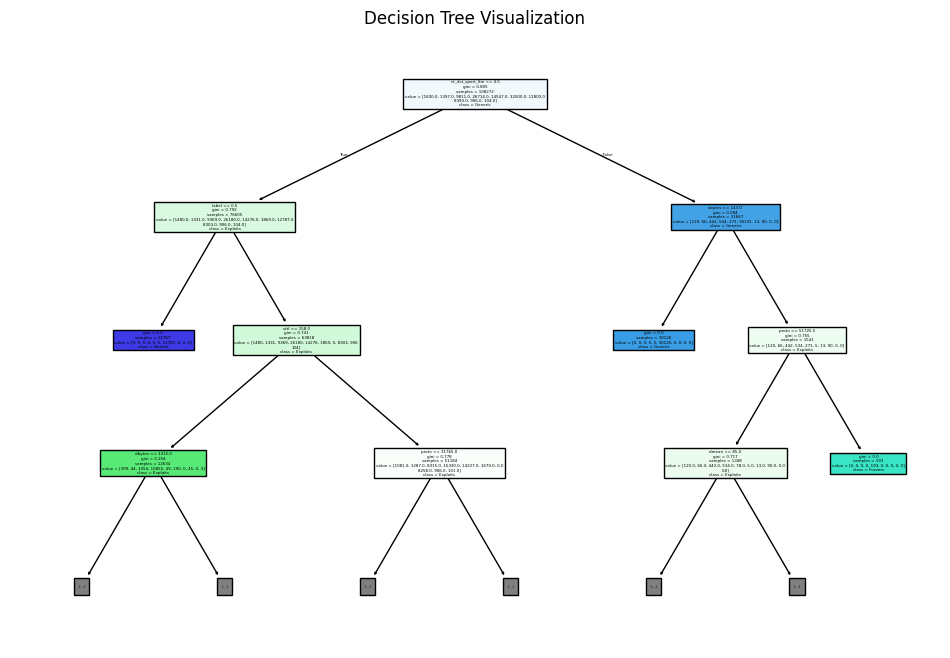

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("Threats (1).csv")
print(df.head())

# Function for frequency encoding
def frequency_encoding(df, categorical_columns):
    encoding = {}
    for col in categorical_columns:
        freq = df[col].value_counts()
        df[col] = df[col].map(freq)
        encoding[col] = freq
    return df, encoding

# Drop unnecessary columns
df.drop(['Unnamed: 0', 'id'], axis='columns', inplace=True)
df, freq = frequency_encoding(df, ['proto', 'service', 'state'])

# Encode labels
labels = LabelEncoder()
df['attack_cat'] = labels.fit_transform(df['attack_cat'])

# Split features and target
predict_feature = df['attack_cat'].to_numpy()
df.drop(['attack_cat'], axis='columns', inplace=True)
features = df.to_numpy()

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, predict_feature, test_size=0.2, random_state=42, stratify=predict_feature)

# Function for KFold Cross Validation
def KFold_crossval(x, y, classifier):
    kfold = KFold(n_splits=6)
    accuracy = []
    for idx_train, idx_test in kfold.split(x, y):
        classifier.fit(x[idx_train], y[idx_train])
        y_predict = classifier.predict(x[idx_test])
        acc = accuracy_score(y[idx_test], y_predict)
        accuracy.append(acc)
    avg_acc = sum(accuracy) / len(accuracy)
    print(f"Average Accuracy = {avg_acc:.4f}")
    print("Accuracy per fold:", accuracy)
    return classifier

# Train Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

# Confusion Matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, feature_names=df.columns, class_names=labels.classes_, max_depth=3)
plt.title("Decision Tree Visualization")
plt.show()

# Train AdaBoost with optimized parameters
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, learning_rate=0.5)
abc.fit(x_train, y_train)
y_pred_boosted = abc.predict(x_test)

# Confusion Matrix for Boosted Model
conf_matrix_boosted = confusion_matrix(y_test, y_pred_boosted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_boosted, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Boosted Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print accuracy comparison
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_boosted = accuracy_score(y_test, y_pred_boosted)
print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Boosted Decision Tree Accuracy: {acc_boosted:.4f}")
